/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


{'data_root': '/media/julian/Maxtor/DATA/cmu_panoptic',
 'nodes': [1, 15, 3, 13, 8],
 'panels': [1, 6, 14, 18, 5],
 'seq_name': '160422_ultimatum1'}
step 1: elapsed 1.6790554523468018
step 2: elapsed 0.02465343475341797
step 3: elapsed 0.1605696678161621
step 4: elapsed 0.7968261241912842
-------------------------------------------
Handle transitivity:
	Intra:		 0
	Intra(choice):	 3
	Inter:		 23
	Inter(choice):	 24
-------------------------------------------
	Time =  65  ms
	result: 0

	Total cost: 94.80212349753162

# valid points:		 52
# invalid points:	 27
step 5: elapsed 0.06993508338928223
step 7: elapsed 0.044785499572753906

total elapsed: 2.779526948928833


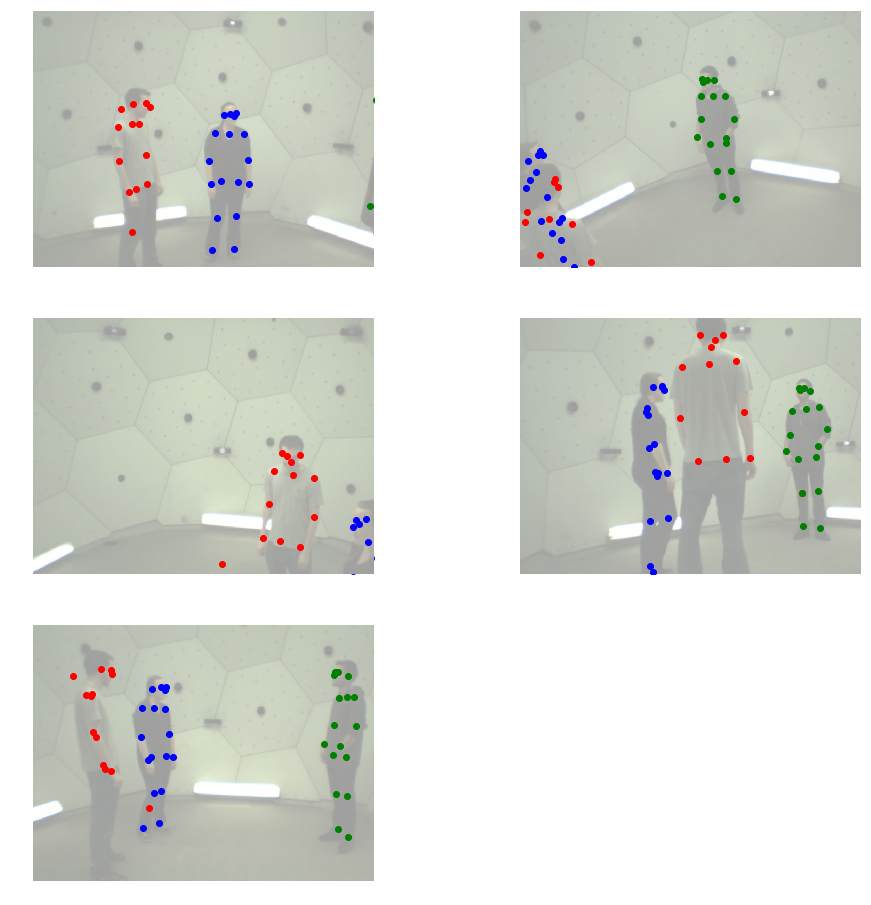

In [1]:
%matplotlib inline
# ---- settings ----
import json
from pprint import pprint
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time

from mvpose.data import cmu_panoptic

root = Settings['CMU']['data_root']

pprint(Settings['CMU'])
    
FRAME = 2000

panels = Settings['CMU']['panels']
nodes = Settings['CMU']['nodes']

seq_name = Settings['CMU']['seq_name']

Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('cmu', Im, FRAME, dir='/home/julian/Temp')

# ==================================
from mvpose import pose
from mvpose.algorithm import graphcut
from mvpose.algorithm.settings import get_settings

_start = time()
Debug, detections = pose.estimate_heuristic(Calib, heatmaps, pafs,
                                  settings=get_settings(
                                      scale_to_mm=10),
                                  debug=True)
_end = time()
print('\ntotal elapsed:', _end - _start)
# ==================================


from mvpose.algorithm.candidate_selection import project_human_to_2d


Humans = detections

fig = plt.figure(figsize=(16,16))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(3,2,1+idx)
    ax.axis('off')
    ax.set_xlim([0, 640])
    ax.set_ylim([480, 0])
    im = Im[idx]
    mapx = cam.mapx
    mapy = cam.mapy
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, cam)
        for p in human2d:
            if p is not None:
                ax.scatter(p[0], p[1], color=colors[pid])
    
plt.show()

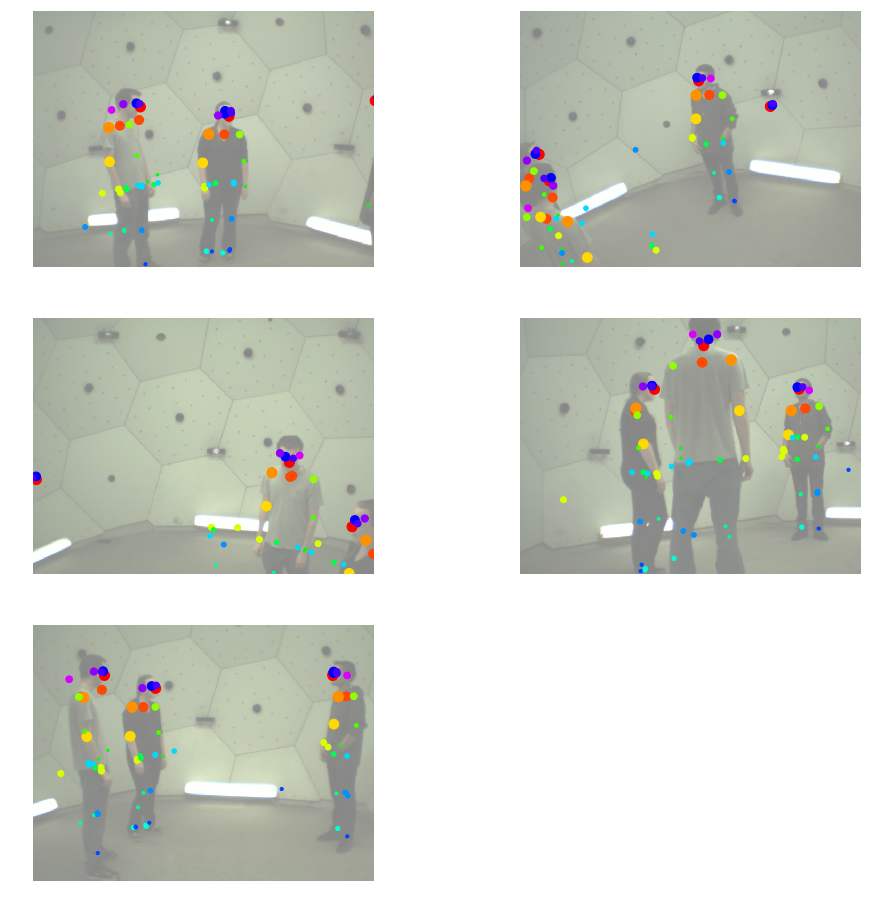

In [2]:
colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,16))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(3, 2, cid+1)
    ax.set_xlim(0, 640)
    ax.set_ylim(480, 0)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.meanshift.centers3d[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color=colors[jid], s=score*20)
    
plt.show()

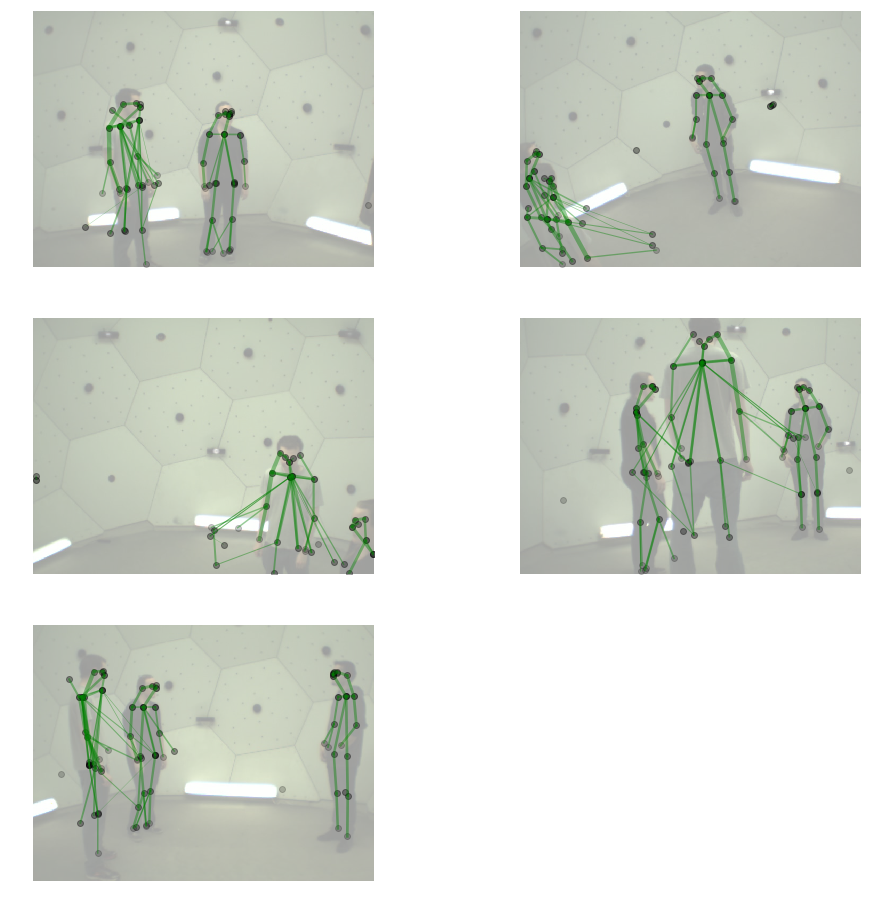

In [3]:
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ

fig = plt.figure(figsize=(16,16))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(3,2,1+idx)
    ax.axis('off')
    ax.set_xlim(0, 640)
    ax.set_ylim(480, 0)
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
        candA = Debug.meanshift.centers3d[a][:,0:3]
        candB = Debug.meanshift.centers3d[b][:,0:3]
        W = Debug.limbs3d[lid]
        n, m = W.shape
        assert n == len(candA) and m == len(candB)
        
        ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
        ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)

        ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='black', alpha=0.2)
        ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='black', alpha=0.2)
        
        maskA_sq = np.squeeze(maskA)
        maskB_sq = np.squeeze(maskB)
        if len(maskA_sq.shape) == 0:
            maskA_sq = np.expand_dims(maskA_sq, axis=0)
        if len(maskB_sq.shape) == 0:
            maskB_sq = np.expand_dims(maskB_sq, axis=0)
        
        for _a in maskA_sq:
            for _b in maskB_sq:
                w = W[_a,_b]
                Ax,Ay = ptsA2d[_a]
                Bx,By = ptsB2d[_b]
                if w > 0:
                    ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*10, alpha=0.4)
                elif w > -99999:
                    ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*10, alpha=0.4)

plt.show()